In [1]:
import pandas as pd

from concurrent.futures import ThreadPoolExecutor
import concurrent.futures


import plotly.graph_objects as go

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output, State
import time


In [2]:
start_year = 2021
end_year = 2022

In [3]:
averages = pd.read_html('https://www.basketball-reference.com/leagues/NBA_stats_per_game.html#stats', header=1)[0]

averages= averages.dropna()

averages = averages[averages['Season']!='Season']
averages['PTS'] = averages['PTS'].astype(float)
averages['FGA'] = averages['FGA'].astype(float)
averages['FTA'] = averages['FTA'].astype(float)
averages['TS%'] = averages['PTS']/(2* (averages['FGA'] + .44 *averages['FTA'] ))
averages['TS%'] = averages['PTS']/(2* (averages['FGA'] + .44 *averages['FTA'] ))
averages = averages[['TS%','Season']]
averages['Season'] = averages['Season'].str[:4]
averages['Season'] = averages['Season'].astype(int)
averages['Season']+=1
averages = averages[averages['Season']>=start_year]
averages = averages[averages['Season']<=end_year]
averages = averages.iloc[::-1]



In [4]:
s_data = averages.to_dict('split')['data']
seasons = {}
options = []
for i in s_data:
    seasons[int(i[1])] = float(i[0])
    options.append(int(i[1]))

In [5]:
def get_table(year,minutes):
    link_1 = 'https://www.basketball-reference.com/playoffs/NBA_'+str(year)+'_per_poss.html#per_poss_stats'
    df = pd.read_html(link_1)[0]
   
    df = df[df["MP"].notna()]
    df = df[df['MP'] != 'MP']
    df['MP'] = df['MP'].astype(float)
    df['PTS'] = df['PTS'].astype(float)
    df['FTA'] = df['FTA'].astype(float)
    df['FGA'] = df['FGA'].astype(float)

    df['TS%'] = df['PTS']/(2* (df['FGA'] + .44 *df['FTA'] ))

    df = df[df['MP'] >minutes]
    df['TS%'] *=100
    df['G'] = df['G'].astype(int)

    
    return [ df[['Player','TS%','PTS','MP','Tm','G']],year]


In [6]:

def get_tablesn(start_year,stop_year,minutes):
    tables = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
    # Start the load operations and mark each future with its URL
        
        
        future_to_url = {executor.submit(get_table, 
                                     year,minutes):
                     year for year in range(start_year,stop_year +1)}
    for future in concurrent.futures.as_completed(future_to_url):
        val = future.result()[0]
        key = future.result()[1]
        tables[key] = val
            #print(df.head())
        #tables.append(future.result())

    return tables

In [7]:
link_1 ='https://www.basketball-reference.com/leagues/NBA_2011_per_poss.html#per_poss_stats'
link_2 = 'https://www.basketball-reference.com/leagues/NBA_2011_advanced.html#advanced_stat'
link_3 ='https://www.basketball-reference.com/playoffs/NBA_2022_per_poss.html#per_poss_stats'

df = pd.read_html(link_3)[0]
df = df[df["MP"].notna()]
df = df[df['MP'] != 'MP']
df['MP'] = df['MP'].astype(float)
df['PTS'] = df['PTS'].astype(float)
df['FTA'] = df['FTA'].astype(float)
df['FGA'] = df['FGA'].astype(float)

df['TS%'] = df['PTS']/(2* (df['FGA'] + .44 *df['FTA'] ))
df['TS%']

df = df.round({'TS%': 1})

In [8]:
df.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Unnamed: 29',
       'ORtg', 'DRtg', 'TS%'],
      dtype='object')

In [9]:

def get_tables(start_year,stop_year,minutes):

    tables = {}
    for i in range(start_year,stop_year + 1):
        result = get_table(i,minutes)
        tables[result[1]] = result[0] 
        
    return tables

def playoff_tables(start_year,stop_year,minutes):
    tables = []
    for i in range(start_year,stop_year + 1):
   

        df = get_table(i,minutes)
        df = df[0]
        tables.append(df)
    return tables



In [21]:
import time
minutes = 100
st = time.time()
start_year = 2021
end_year = 2021
tables = get_tables(start_year,end_year,minutes)
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.7952604293823242 seconds


In [22]:
def get_buttons(teams,year,df):
    my_list = []
    i = 0
    length = len(teams)
    seen = [False for i in range(length+ 1) ]

    seen[i] = True
    my_list.append(dict(label = 'all_teams',
                      method = 'update',
                      args = [{'visible':[i for i in seen]},
                              {'title': 'All',
                               'showlegend':False}]))
    seen[i] = False
    i +=1
    for team in teams:
        #print(i)
        df_team = df[df['Tm'] == team]
        seen[i] = True

        my_list.append(dict(label = team,
                      method = 'update',

                      args = [{'visible':[i for i in seen]},
                              {'title': str(year) + ' '+team,
                               'showlegend':False}]))
        seen[i] = False
        i+=1
    return my_list


In [23]:
#zmax = df['TS%'].max()
#zmin = df['TS%'].min()
#zmin



In [24]:
def full_trace(fig,df,zmin,zmax,av_shooting):
    df = df[df['Tm']!= 'TOT']
    fig.add_trace(
            go.Scatter(

                visible = True,
                x = df['PTS'],
                y = df['TS%'],
                customdata = df['TS%'] - av_shooting,

                
                text = df['Player']+' - ' + df['Tm'],
                hovertemplate =
                '<b>%{text}</b>'+
        '<br><i>Points per 100 Possesions</i>: %{x:.2f}<br>'+
        'True Shooting: %{y:.2f}'
                + ' <br>Relative True Shooting: %{customdata:.2f}<extra></extra></br>'
        ,
                name = 'All',
                marker=dict(
                cmin=zmin ,
                cmax=zmax,
                size=df['MP'] / df['G'],
                colorbar=dict(
                title="True Shooting %"


            ),
            colorscale="plasma",
            color=  df['TS%'],

        ),


        mode="markers"
            ))
    return fig
    

In [25]:
def team_trace(fig,df,teams,zmin,zmax,av_shooting):
    for team in teams:
        df_team = df[df['Tm'] == team]


        fig.add_trace(
            go.Scatter(
                
                visible = False,
                x = df_team['PTS'],
                y = df_team['TS%'],
                customdata = df_team['TS%'] - av_shooting,
                
                text = df_team['Player']+' - ' + df_team['Tm'],
                hovertemplate =
                '<b>%{text}</b>'+
        '<br><i>Points per 100 Possesions</i>: %{x:.2f}<br>'+
        'True Shooting: %{y:.2f}'
                + ' <br>Relative True Shooting: %{customdata:.2f}<extra></extra></br>'
        ,
                name = team,
                marker=dict(
                cmin=zmin ,
                cmax=zmax,
                size=df['MP'] / df['G'],
                colorbar=dict(
                title="True Shooting"


            ),
            colorscale = 'Plasma',
            
            color=  df_team['TS%'],

        ),


        mode="markers"
            )

        ) 
    return fig

In [26]:
def season_graph(df,year,true_shooting):
    fig = go.Figure()
    teams = list(df['Tm'].unique())
    my_buttons = get_buttons(teams,year,df)
    zmax = df['TS%'].max()
    zmin = df['TS%'].min()
    fig.update_layout(
        title={
        'text':str(year) +" Playoffs",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    updatemenus=[go.layout.Updatemenu(
            active=0,
            buttons= my_buttons,
            direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,


    )],
    font=dict(
        size=15,
    )
    )
   
    fig = full_trace(fig,df,zmin,zmax,true_shooting)
    fig = team_trace(fig,df,teams,zmin,zmax,true_shooting)

    fig.update_layout(yaxis_range=[int(zmin -3),int(zmax +2)], xaxis_range = [0,50])
    fig.update_yaxes(tickvals=[i for i in range(int(zmin)-3,int(zmax)+3,5)])
    fig.update_xaxes(tickvals = [i for i in range (5,50,5)], title_text = 'Points per 100 Possesions')
    fig.add_hline(y=true_shooting)
    fig.update_layout(
        width = 1400,
        height = 700,
        autosize=True,
        annotations=[
        go.layout.Annotation(
            showarrow=False,
            text='Source: Basketball Reference',
            y =zmin
            
        )]
    )  
    return fig

In [27]:
#df = tables[2022]
print(seasons)

{2021: 0.5719854682014858, 2022: 0.5658099369730704}


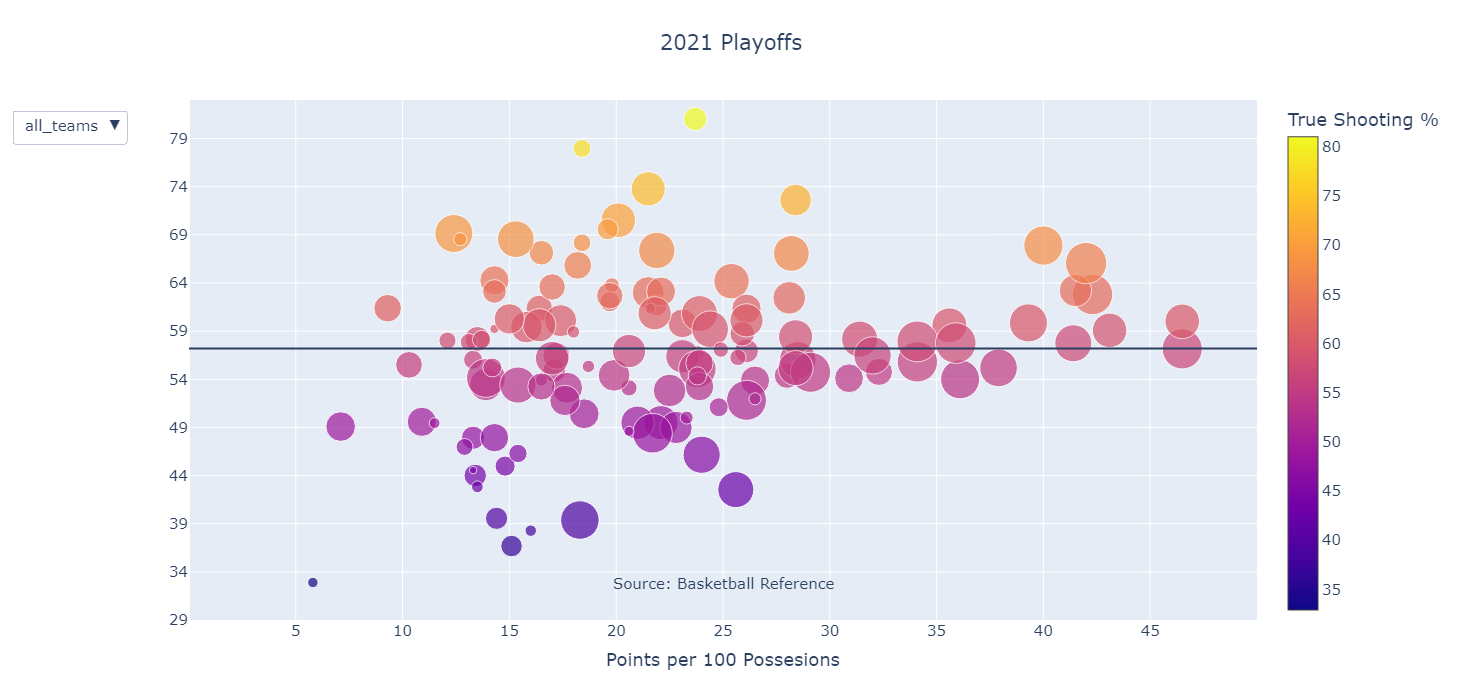

In [28]:
year = 2021
df = tables[year]
df['G'] = df['G'].astype(int)

fig = season_graph(df,year,seasons[2021]*100)
fig.show()

In [ ]:


app = dash.Dash(
      meta_tags=[
        {"name": "viewport", "content": "width=device-width, initial-scale=1"}
    ],
)
    

In [ ]:
mess_1 = 'Bubble size corresponds to minutes played'
mess_2 = 'Players with less than ' +str(minutes)+ ' minutes are excluded'
server = app.server

app.layout = html.Div(
    
    children=[
    html.H1(children='Scoring by Year', style={'text-align': 'center'}),
    html.Div(children='Player Scoring vs Player Efficiency', style={'text-align': 'center'}),
    html.Ul(children = [html.Li(mess_1), html.Li(mess_2) ]),

    html.Div([
        html.Label(['Choose a season:'],style={'font-weight': 'bold'}),
        dcc.Dropdown(
            id='dropdown',
            options=options,
                
            value=start_year,
            style={"width": "60%"}),
        
    html.Div(dcc.Graph(id='graph',
                        figure=dict(layout=dict(autosize=True)),
            config=dict(responsive=True),  style={'display': 'flex','width':1400,'height':800}))      
        ]),

])

@app.callback(
    Output('graph', 'figure'),
    [Input(component_id='dropdown', component_property='value')]
)

def update_output(value):
    
    fig = season_graph(tables[value],value,seasons[value]* 100)
    return fig


# Run app and display result inline in the notebook
if __name__ == '__main__':
    app.run_server(port=80)

In [ ]:
seasons